# Fig. AR Climatology

Plot domain and variables used for EOF analysis

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from ar_funcs import preprocess_ar_area_subregions

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


In [4]:
# label strings

ivt_units = 'kg m$^{-1}$ s$^{-1}$'

## Data

### 1) AR time series

In [5]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_ERAI_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice('1979-01-01', '2018-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### 2) ERA reanalysis

In [7]:
# Select lat/lon grid
lonmin = 0
lonmax = 120
latmin = 0
latmax =  50

### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT anomaly data
filepath_pattern = path_to_data + 'ERA5/IVT/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

era

ds size in GB 2.85



<xarray.Dataset>
Dimensions:  (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
Data variables:
    ivte     (time, lat, lon) float32 -1.949585 0.36058044 ... 336.15054
    ivtn     (time, lat, lon) float32 -42.10005 -40.867218 ... -32.044495

### Select data subset

In [8]:
# Add AR time series to era5; set as coordinate variables
era['ar'] = ('time', df.ar)
era = era.set_coords('ar')

era['location'] = ('time', df.location)
era = era.set_coords('location')

# print dataset
print(era)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    ivte      (time, lat, lon) float32 -1.949585 0.36058044 ... 336.15054
    ivtn      (time, lat, lon) float32 -42.10005 -40.867218 ... -32.044495


In [9]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select DJF months
idx = (era.time.dt.month >= 12) | (era.time.dt.month <= 2)
era = era.sel(time=idx)

# Select AR days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 371)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    ivte      (time, lat, lon) float32 236.6193 241.0619 ... 110.214935
    ivtn      (time, lat, lon) float32 -19.468597 -21.229797 ... -43.313354


## Calculate climatology

In [10]:
# Mean IVT of AR days in DJF
era_ar_clim = era_ar.mean(dim='time')

## Create figure

In [12]:
# Data for plotting
lons = era_ar_clim.lon.values
lats = era_ar_clim.lat.values
uvec = era_ar_clim.ivte.values
vvec = era_ar_clim.ivtn.values
ivt = np.sqrt(uvec**2 + vvec**2)

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # set seaborn style
# sns.set()
# sns.set_style("ticks", {'patch.force_edgecolor':False})


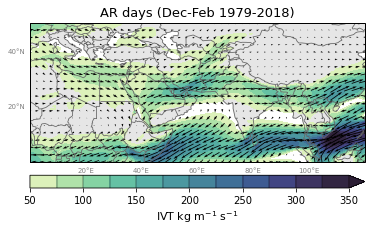

In [15]:

cmap = cmo.deep
clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)


# Create figure
fig = plt.figure(figsize=(6,6))

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
#ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# IVT (filled contour)
clevs_ivt = np.arange(50,351,25)
cf = ax.contourf(lons, lats, ivt, transform=datacrs, extend='max',
                levels=clevs_ivt, cmap=clipcmap)

# IVT vectors
ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
    color='black', regrid_shape=20, pivot='middle')

# Colorbar 
cb = fig.colorbar(cf, orientation='horizontal', drawedges=True, pad=0.04, aspect=25)
cb.set_label('IVT kg m$^{-1}$ s$^{-1}$', fontsize=11)
cb.ax.tick_params(labelsize=10)

# Title
ax.set_title('AR days (Dec-Feb 1979-2018)', loc='center', fontsize=13)

# show figure
filepath = path_to_figs + 'ar_ivt_clim_djf' + '.png'
plt.savefig(filepath, bbox_inches='tight', dpi=200)
plt.show()
